# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    #print('test')
    #print(mask)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)

    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    print('test')
    print(X_train.shape)
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    print(X_train.shape)
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

test
(49000, 3072)
(49000, 3073)
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.346286
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.319827 analytic: -0.319827, relative error: 2.697955e-07
numerical: 2.833931 analytic: 2.833931, relative error: 9.437531e-09
numerical: 1.108406 analytic: 1.108406, relative error: 5.681343e-08
numerical: -0.200888 analytic: -0.200888, relative error: 3.598049e-07
numerical: 0.755566 analytic: 0.755566, relative error: 3.116748e-08
numerical: -2.984737 analytic: -2.984737, relative error: 7.926271e-09
numerical: -0.168249 analytic: -0.168249, relative error: 3.031508e-07
numerical: 0.403946 analytic: 0.403946, relative error: 1.596686e-07
numerical: -0.743200 analytic: -0.743200, relative error: 5.421782e-08
numerical: 2.817236 analytic: 2.817236, relative error: 2.089214e-09
numerical: -0.904085 analytic: -0.912229, relative error: 4.483854e-03
numerical: -3.044107 analytic: -3.045898, relative error: 2.942008e-04
numerical: -1.315747 analytic: -1.320070, relative error: 1.639907e-03
numerical: -0.085132 analytic: -0.080886, relative error: 2.557726e-02
numerical: 0.373

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.346286e+00 computed in 0.013234s
vectorized loss: 2.346286e+00 computed in 0.012930s
Loss difference: 0.000000
Gradient difference: 0.000000


In [21]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
softmaxtp = Softmax()

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-6, 5e-7]
learning_rates = np.logspace(-6.5, -5.5 , num = 3)
learning_rates = [1e-9]
#regularization_strengths = np.logspace(2e+3, 1e+4, num =10)
regularization_strengths = np.linspace(5.2e+3, 5.4e+3, num =10)

#regularization_strengths = [2.78e3]



################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
# X_train (N,D)
# W (D,C)
# y (N,1)

for rates in learning_rates:
    for regs in regularization_strengths:
        softmaxtp.__init__()
        loss_hist = softmaxtp.train(X_dev, y_dev, learning_rate=1e-6, reg=regs, num_iters=1500, verbose=True)
        loss_hist = softmaxtp.train(X_dev, y_dev, learning_rate=rates, reg=regs, num_iters=1500, verbose=True)        
        y_train_pred = softmaxtp.predict(X_train)
        tp = np.mean(y_train_pred == y_train)
        y_val_pred = softmaxtp.predict(X_val)
        vp = np.mean(y_val_pred == y_val)
        results[(rates, regs)] = (tp,vp) 
        best_val = np.maximum(vp,best_val)
        if(vp == best_val):
            best_softmax = softmaxtp 
            loss_hist = best_softmax.train(X_train, y_train, learning_rate=rates, reg=regs, num_iters=1500, verbose=True)

        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))   
    
        
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 86.838688
iteration 100 / 1500: loss 11.526161
iteration 200 / 1500: loss 2.826381
iteration 300 / 1500: loss 1.661556
iteration 400 / 1500: loss 1.522630
iteration 500 / 1500: loss 1.537799
iteration 600 / 1500: loss 1.555193
iteration 700 / 1500: loss 1.508698
iteration 800 / 1500: loss 1.642123
iteration 900 / 1500: loss 1.568200
iteration 1000 / 1500: loss 1.542998
iteration 1100 / 1500: loss 1.570196
iteration 1200 / 1500: loss 1.518284
iteration 1300 / 1500: loss 1.542224
iteration 1400 / 1500: loss 1.445795
iteration 0 / 1500: loss 1.652795
iteration 100 / 1500: loss 1.527368
iteration 200 / 1500: loss 1.556999
iteration 300 / 1500: loss 1.517255
iteration 400 / 1500: loss 1.486686
iteration 500 / 1500: loss 1.582157
iteration 600 / 1500: loss 1.452166
iteration 700 / 1500: loss 1.555810
iteration 800 / 1500: loss 1.507144
iteration 900 / 1500: loss 1.595714
iteration 1000 / 1500: loss 1.620896
iteration 1100 / 1500: loss 1.500406
iteration 1200 / 1500: 

iteration 200 / 1500: loss 2.629158
iteration 300 / 1500: loss 1.720186
iteration 400 / 1500: loss 1.555789
iteration 500 / 1500: loss 1.545194
iteration 600 / 1500: loss 1.488492
iteration 700 / 1500: loss 1.571316
iteration 800 / 1500: loss 1.605957
iteration 900 / 1500: loss 1.462230
iteration 1000 / 1500: loss 1.543490
iteration 1100 / 1500: loss 1.658851
iteration 1200 / 1500: loss 1.545283
iteration 1300 / 1500: loss 1.621775
iteration 1400 / 1500: loss 1.451325
iteration 0 / 1500: loss 1.541911
iteration 100 / 1500: loss 1.607826
iteration 200 / 1500: loss 1.593847
iteration 300 / 1500: loss 1.490091
iteration 400 / 1500: loss 1.546219
iteration 500 / 1500: loss 1.617795
iteration 600 / 1500: loss 1.477994
iteration 700 / 1500: loss 1.589846
iteration 800 / 1500: loss 1.525417
iteration 900 / 1500: loss 1.546123
iteration 1000 / 1500: loss 1.568410
iteration 1100 / 1500: loss 1.579170
iteration 1200 / 1500: loss 1.560732
iteration 1300 / 1500: loss 1.523823
iteration 1400 / 1500

In [22]:
# evaluate on test set
# Evaluate the best softmax on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.315000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

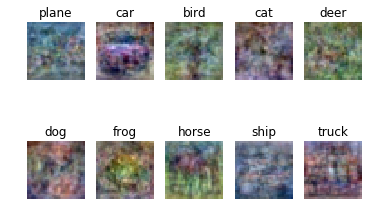

In [17]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])